## How does the approximation of WH ~ X perform as we increase the rank k?

In [4]:
from ristretto import nmf
import numpy
import matplotlib.pyplot as plt
import pandas

def nmf_approximation_error(matrix, k, method = 'nmf_fhals'):
    if method == 'nmf_fhals':
        W,H = nmf.nmf_fhals(matrix, k)
        return numpy.linalg.norm(matrix - W.dot(H))
    elif method == 'rnmf_fhals':
        W,H = nmf.rnmf_fhals(matrix, k)
        return numpy.linalg.norm(matrix - W.dot(H))
    else:
        return None


nmf_error_tracker = {}
rnmf_error_tracker = {}
X = numpy.random.rand(1000,1000)
for k in range(200, 500, 50):
    nmf_error = []
    for trial in xrange(3):
        nmf_error.append(nmf_approximation_error(X, k, method = 'nmf_fhals'))
    nmf_error_tracker[k] = numpy.mean(nmf_error)

    rnmf_error = []
    for trial in xrange(3):
        rnmf_error.append(nmf_approximation_error(X, k, method = 'nmf_fhals'))
    rnmf_error_tracker[k] = numpy.mean(rnmf_error)

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:3161: RuntimeWarning: Second argument is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


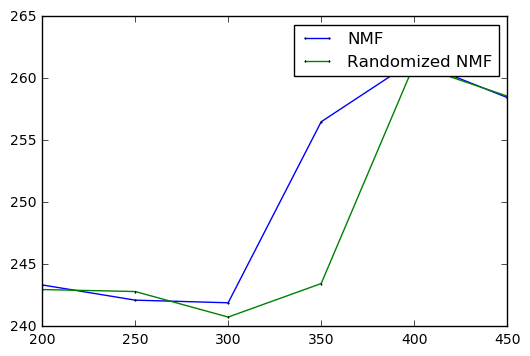

In [5]:
nmf_df = pandas.DataFrame([nmf_error_tracker.keys(), nmf_error_tracker.values()]).T.sort_values(0)
nmf_df.columns = ['x','y']
rnmf_df = pandas.DataFrame([rnmf_error_tracker.keys(), rnmf_error_tracker.values()]).T.sort_values(0)
rnmf_df.columns = ['x','y']
plt.plot('x', 'y', data = nmf_df, linestyle='-', marker='o', markersize = 1, label='NMF')
plt.plot('x', 'y', data = rnmf_df, linestyle='-', marker='d', markersize = 1, label='Randomized NMF')
plt.legend()
plt.show()
plt.close()

## NMF Code

In [57]:
from __future__ import division

import numpy as np
import scipy as sci
from scipy import linalg

from _fhals_update import _fhals_update
from _rfhals_update import _rfhals_update

epsi = np.finfo(np.float32).eps

def snmf_fhals(A, k, init='normal', tol=1e-4, maxiter=100, verbose=False):
    """
    Nonnegative Matrix Factorization.
    
    Hierarchical alternating least squares algorithm
    for computing the approximate low-rank nonnegative matrix factorization of 
    a square `(m, m)` matrix `A`. Given the target rank `k << m`, 
    the input matrix `A` is factored as `A = W Wt`. The nonnegative factor 
    matrices `W` and `Wt` are of dimension `(m, k)` and `(k, m)`, respectively.
           
    
    Parameters
    ----------
    A : array_like, shape `(m, m)`.
        Real nonnegative input matrix.
    
    k : integer, `k << m`.
        Target rank.
    
    init : str `{'normal'}`. 
        'normal' : Factor matrices are initialized with nonnegative 
                   Gaussian random numbers.
            
    tol : float, default: `tol=1e-4`.
        Tolerance of the stopping condition.
        
    maxiter : integer, default: `maxiter=100`.
        Number of iterations.   
        
    verbose : boolean, default: `verbose=False`.
        The verbosity level.        
    
    
    Returns
    -------
    W:  array_like, `(m, k)`.
        Solution to the non-negative least squares problem.
    """    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Error catching
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    m, n = A.shape  

    assert m == n
    
    if (A < 0).any():
        raise ValueError("Input matrix with nonnegative elements is required.")    
    
    if  A.dtype == sci.float32: 
        data_type = sci.float32
        
    elif A.dtype == sci.float64: 
        data_type = sci.float64  

    else:
        raise ValueError("A.dtype is not supported.")    
    

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                            
    # Initialization methods for factor matrices W and H
    # 'normal': nonnegative standard normal random init
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    
    if init == 'normal':
        m, n = A.shape
        assert m == n
        W = sci.maximum(0.0, sci.random.standard_normal((m, k)))
        Ht = W.copy()
    else:
        raise ValueError('Initialization method is not supported.')
    #End if

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Iterate the HALS algorithm until convergence or maxiter is reached
    # i)   Update factor matrix H and normalize columns   
    # ii)  Update low-dimensional factor matrix W
    # iii) Compute fit log( ||A-WH|| )
    #   -> break if fit <-5 or fit_change < tol
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    
    for niter in range(maxiter): 
        violation = 0.0

        # Update factor matrix H
        WtW = W.T.dot(W)
        AtW = A.T.dot(W)

        #violation += _fhals_update(Ht, WtW, AtW)
        violation += _fhals_update(W, WtW, AtW)
        #print violation
        #Ht /= sci.maximum(epsi, sci.linalg.norm(Ht, axis=0))
        W /= sci.maximum(epsi, sci.linalg.norm(W, axis=0))
        # Update factor matrix W
        #HHt = Ht.T.dot(Ht)
        #AHt = A.dot(Ht) # Rotate AHt back to high-dimensional space

        #violation += _fhals_update(W, HHt, AHt)

        # Compute stopping condition.
        if niter == 0:
            violation_init = violation

        if violation_init == 0:
            break       

        fitchange = violation / violation_init
        
        if verbose == True:
            print('Iteration: %s fit: %s, fitchange: %s' %(niter, violation, fitchange))        

        if fitchange <= tol:
            break

    #End for

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                            
    # Return factor matrices
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    if verbose == True:
        print('Final Iteration: %s fit: %s' %(niter, violation)) 
        
    #return( W, Ht.T )
    return(W,W.T)


In [112]:
import numpy
import nmf

X = numpy.random.rand(100,100)
X_sym = (X + X.T)/2
W, H = snmf_fhals(X_sym, 100)
assert (W == H.T).all()
print numpy.linalg.norm(W.dot(H) - X)

54.8391511137


In [113]:
B,C = nmf.nmf_fhals(X_sym,100)
print (B == C.T).all()
print numpy.linalg.norm(B.dot(C) - X)

False
20.9915665065


In [114]:
from sklearn.decomposition import NMF

model = NMF(n_components=100, init='random', random_state=0)
W = model.fit_transform(X_sym)
H = model.components_

In [115]:
numpy.linalg.norm(W.dot(H) - X)

20.643145964929008